In [1]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
import seaborn as sns
from Models import probitModel, logisticModel
from util import *
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import *
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import *
from sklearn.metrics import make_scorer, f1_score
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from joblib import Memory
from shutil import rmtree

from sklearn.metrics import get_scorer
from datetime import datetime

from lightgbm import LGBMClassifier
from bayes_opt import BayesianOptimization

import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='lightgbm')

In [2]:
SEED = 1

data_folder = 'data'
df = pd.read_csv(os.path.join(data_folder,'mimiciv_traindata.csv'))
df.head()

,Fraction inspired oxygen_mean,Fraction inspired oxygen_min,Fraction inspired oxygen_max,Glucose_mean,Glucose_min,Glucose_max,Heart Rate_mean,Heart Rate_min,Heart Rate_max,Mean blood pressure_mean,...,Temperature_mean,Temperature_min,Temperature_max,Weight_mean,Weight_min,Weight_max,pH_mean,pH_min,pH_max,mortality
0,0.484615,0.4,0.6,155.181818,52.0,280.0,52.367347,35.0,93.0,87.096154,...,36.356349,35.200000,37.100000,81.419764,81.419764,81.419764,7.328750,7.19,7.40,1.0
1,0.600000,0.5,1.0,127.954545,85.0,177.0,72.660377,58.0,105.0,72.315789,...,36.786325,36.388889,37.055556,93.103510,91.807021,95.000000,7.377143,7.34,7.42,0.0
2,0.481250,0.4,0.8,145.625000,116.0,180.0,107.260000,96.0,118.0,86.462963,...,37.316239,36.611111,37.944444,67.500000,67.500000,67.500000,7.372000,7.29,7.45,0.0
3,0.400000,0.4,0.4,100.142857,77.0,154.0,57.250000,47.0,65.0,69.762712,...,NaN,NaN,NaN,80.403091,76.838485,86.000000,7.161250,6.00,7.36,1.0
4,0.566667,0.4,1.0,138.000000,116.0,155.0,84.015625,64.0,114.0,70.662162,...,36.148990,34.722222,37.666667,NaN,NaN,NaN,7.374444,7.27,7.42,1.0


In [3]:
x = df.drop('mortality',axis=1)
y = df.mortality.values


mortality
0.0    0.749424
1.0    0.250576
Name: proportion, dtype: float64


<Axes: xlabel='mortality'>

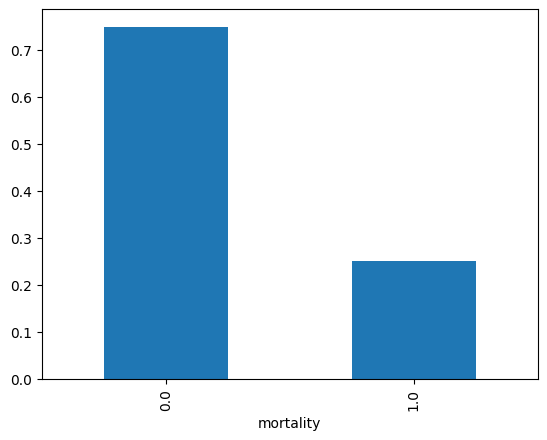

In [4]:
print(df.mortality.value_counts(normalize=True))
df.mortality.value_counts(normalize=True).plot(kind='bar')
#sns.countplot(x='mortality', data=df)

# GridSearchCV for weight of weighted loss

### Probit

In [5]:
probit_pipeline = [
    ('scaler', QuantileTransformer(output_distribution='normal', ignore_implicit_zeros=False)),
    ('imputer', KNNImputer(missing_values=np.nan, n_neighbors=10)),
    ('model',probitModel()),
]

In [6]:
pipe = Pipeline(probit_pipeline)
param_grid = {
    'model__w': np.arange(0.1,1.0,0.05),
}
search = GridSearchCV(pipe, param_grid, cv=5, scoring=make_scorer(f1_score), n_jobs=-1, verbose=3)
search.fit(x,y)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler',
                                        QuantileTransformer(output_distribution='normal')),
                                       ('imputer', KNNImputer(n_neighbors=10)),
                                       ('model', probitModel())]),
             n_jobs=-1,
             param_grid={'model__w': array([0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 ,
       0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95])},
             scoring=make_scorer(f1_score, response_method='predict'),
             verbose=3)

In [7]:
search.best_params_

{'model__w': 0.7500000000000002}

### Logistic Model

In [8]:
logistic_pipeline = [
    ('scaler', QuantileTransformer(output_distribution='normal', ignore_implicit_zeros=False)),
    ('imputer', KNNImputer(missing_values=np.nan, n_neighbors=10)),
    ('model', logisticModel()),
]

In [9]:
pipe = Pipeline(probit_pipeline)
param_grid = {
    'model__w': np.arange(0.1,1.0,0.05),
}
search = GridSearchCV(pipe, param_grid, cv=5, scoring=make_scorer(f1_score), n_jobs=-1, verbose=3)
search.fit(x,y)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler',
                                        QuantileTransformer(output_distribution='normal')),
                                       ('imputer', KNNImputer(n_neighbors=10)),
                                       ('model', probitModel())]),
             n_jobs=-1,
             param_grid={'model__w': array([0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 ,
       0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95])},
             scoring=make_scorer(f1_score, response_method='predict'),
             verbose=3)

In [10]:
search.best_params_

{'model__w': 0.7500000000000002}

# Bayes Opt

## Probit

In [11]:
def probit_cv(l1, l2):
    probit_pipeline = [
        ('scaler', QuantileTransformer(output_distribution='normal', ignore_implicit_zeros=False)),
        ('imputer', KNNImputer(missing_values=np.nan, n_neighbors=10)),
        ('model',probitModel( l1=l1, l2=l2, w=0.75 )),
    ]


    mean_score = cv(probit_pipeline, x.values, y, f1_score, 5, random_state=SEED)

    return mean_score

In [12]:
bo = BayesianOptimization(
    probit_cv, 
    pbounds={
        'l1':(0,5),
        'l2':(0,5),
    },                              
    verbose=2
)

In [13]:


start = datetime.now()

bo.maximize(init_points=3, n_iter=100)

time_elapsed = datetime.now() - start

print('Time elapsed:',time_elapsed)

|   iter    |  target   |    l1     |    l2     |
-------------------------------------------------
| 1         | 0.4007    | 4.509     | 0.3644    |
| 2         | 0.4007    | 4.185     | 3.262     |
| 3         | 0.4007    | 1.571     | 2.776     |
| 4         | 0.4007    | 0.3758    | 4.004     |
| 5         | 0.4007    | 0.05381   | 0.02846   |
| 6         | 0.4007    | 4.995     | 4.975     |
| 7         | 0.4007    | 0.9412    | 2.342     |
| 8         | 0.4007    | 2.681     | 0.5035    |
| 9         | 0.4007    | 4.846     | 4.983     |
| 10        | 0.4548    | 0.02237   | 0.0465    |
| 11        | 0.4007    | 2.773     | 0.9516    |
| 12        | 0.4007    | 4.204     | 1.165     |
| 13        | 0.4007    | 1.948     | 3.649     |
| 14        | 0.4007    | 0.4097    | 1.428     |
| 15        | 0.4007    | 4.845     | 2.662     |
| 16        | 0.4007    | 3.851     | 3.193     |
| 17        | 0.4007    | 0.7022    | 4.932     |
| 18        | 0.4535    | 0.02747   | 0.03851   |


In [14]:
print(bo.max)

{'target': 0.4676509822910999, 'params': {'l1': 0.0017152058742947451, 'l2': 0.0017426383767193965}}


## Logistic

In [15]:
def logistic_cv(l1, l2):

    logistic_pipeline = [
        ('scaler', QuantileTransformer(output_distribution='normal', ignore_implicit_zeros=False)),
        ('imputer', KNNImputer(missing_values=np.nan, n_neighbors=10)),
        ('model', logisticModel(l1=l1, l2=l2, w=0.75)),
    ]

    mean_score = cv(logistic_pipeline, x.values, y, f1_score, 5, random_state=SEED)

    return mean_score

In [16]:
bo = BayesianOptimization(
    logistic_cv, 
    pbounds={
        'l1':(0,5),
        'l2':(0,5),
    },                              
    verbose=2
)

In [17]:
start = datetime.now()

bo.maximize(init_points=3, n_iter=100)

time_elapsed = datetime.now() - start

print('Time elapsed:',time_elapsed)

|   iter    |  target   |    l1     |    l2     |
-------------------------------------------------
| 1         | 0.4007    | 3.483     | 0.4052    |
| 2         | 0.4007    | 1.257     | 3.287     |
| 3         | 0.4007    | 2.097     | 4.411     |
| 4         | 0.4007    | 2.892     | 0.2721    |
| 5         | 0.4007    | 4.997     | 4.93      |
| 6         | 0.4007    | 0.07054   | 0.03607   |
| 7         | 0.4007    | 1.683     | 1.047     |
| 8         | 0.4007    | 1.693     | 2.549     |
| 9         | 0.4007    | 4.925     | 4.965     |
| 10        | 0.4007    | 0.01044   | 4.984     |
| 11        | 0.4007    | 4.901     | 0.01479   |
| 12        | 0.4007    | 0.02372   | 4.931     |
| 13        | 0.4007    | 0.7929    | 3.52      |
| 14        | 0.4007    | 1.643     | 4.206     |
| 15        | 0.4007    | 1.929     | 2.564     |
| 16        | 0.4007    | 3.926     | 3.902     |
| 17        | 0.4007    | 4.99      | 0.01941   |
| 18        | 0.4007    | 4.994     | 0.01555   |


In [18]:
print(bo.max)

{'target': 0.46367225134275813, 'params': {'l1': 0.0026729260611141337, 'l2': 0.017135267186066394}}


## LightGBM

In [19]:


def lightgbm_cv(
        max_depth, num_leaves, 
        min_data_in_leaf, bagging_fraction, 
        feature_fraction, lambda_l1, lambda_l2,
        min_split_gain, max_bin, drop_rate, max_drop
    ):
    params = {
        "objective": "binary",
        "metric": None,
        "verbosity": -1,
        "boosting_type": "dart",#"gbdt", #
        "is_unbalance": True,
        "num_boost_round": 1000,
        "learning_rate" : 0.03,

        "max_depth" : int(max_depth),
        "num_leaves" : int(num_leaves),
        "min_data_in_leaf": int(min_data_in_leaf),
        "bagging_fraction": bagging_fraction,
        "feature_fraction": feature_fraction,
        "lambda_l1": lambda_l1,
        "lambda_l2": lambda_l2,
        "min_split_gain": min_split_gain,
        "max_bin": int(max_bin),
        # dart param
        "drop_rate": drop_rate,
        "max_drop": int(max_drop)
    }

    lightgbm_pipeline = [
        ('scaler', QuantileTransformer(output_distribution='normal', ignore_implicit_zeros=False)),
        #('imputer', KNNImputer(missing_values=np.nan, n_neighbors=10)),
        ('model', LGBMClassifier(**params)),
    ]

    mean_score = cv(lightgbm_pipeline, x.values, y, f1_score, 5, random_state=SEED)

    return mean_score

In [20]:
bo = BayesianOptimization(
    lightgbm_cv, 
    pbounds={
        "max_depth" : (3, 10),
        "num_leaves" : (20, 100),
        "min_data_in_leaf": (1, 50),
        "bagging_fraction": (0.5, 1.0),
        "feature_fraction": (0.5, 1.0),
        "lambda_l1": (0, 10),
        "lambda_l2": (0, 10),
        "min_split_gain": (0, 0.1),
        "max_bin": (50,255),
        # dart param
        "drop_rate": (0,0.5),
        "max_drop": (10,50)
    },                              
    verbose=2
)

In [21]:
start = datetime.now()

bo.maximize(init_points=3, n_iter=100)

time_elapsed = datetime.now() - start

print('Time elapsed:',time_elapsed)

|   iter    |  target   | baggin... | drop_rate | featur... | lambda_l1 | lambda_l2 |  max_bin  | max_depth | max_drop  | min_da... | min_sp... | num_le... |
-------------------------------------------------------------------------------------------------------------------------------------------------------------
| 1         | 0.5006    | 0.8956    | 0.1226    | 0.8551    | 6.372     | 8.736     | 198.0     | 7.339     | 18.83     | 49.64     | 0.0004537 | 98.97     |
| 2         | 0.4978    | 0.57      | 0.07656   | 0.5146    | 1.69      | 3.037     | 110.0     | 5.01      | 34.71     | 8.568     | 0.02567   | 22.24     |
| 3         | 0.4914    | 0.8319    | 0.4626    | 0.6145    | 8.596     | 0.2817    | 121.7     | 9.423     | 31.27     | 18.66     | 0.03893   | 78.49     |
| 4         | 0.5029    | 0.6445    | 0.1674    | 0.638     | 5.428     | 5.874     | 110.0     | 3.635     | 31.95     | 8.0       | 0.07969   | 23.81     |
| 5         | 0.4907    | 0.9854    | 0.4815    | 0.

In [22]:
print(bo.max)

{'target': 0.5187603156714411, 'params': {'bagging_fraction': 0.8724723308209363, 'drop_rate': 0.034065278602600224, 'feature_fraction': 0.6565543286882531, 'lambda_l1': 9.57231659883189, 'lambda_l2': 2.6045833031090373, 'max_bin': 194.39174986790286, 'max_depth': 9.677077280727044, 'max_drop': 16.731502457522605, 'min_data_in_leaf': 9.134689952770877, 'min_split_gain': 0.07082411385144215, 'num_leaves': 20.372707187270535}}
